In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
%matplotlib inline

# Overview

In [8]:
movies = pd.read_csv("MoviesData.csv")
movies.head()

,Titles,Rating,RTCritic,RTFan,IMDb,Metacritic,BoxOffice,Year,Action,Animation,Family,Scifi,Comedy,Drama,International,Romance,Horror,Mystery,Documentary
0,Treasure Planet,PG,69,70,7.1,60,38120554,2002,1,1,1,1,0,0,0,0,0,0,0
1,About Schmidt,R,85,74,7.2,85,65005217,2002,0,0,0,0,1,1,0,0,0,0,0
2,Secretary,R,76,82,7.0,63,4046737,2002,0,0,0,0,1,1,1,1,0,0,0
3,Irreversible,NR,57,80,7.4,51,792200,2002,0,0,0,0,0,1,1,0,0,0,0
4,Big Trouble,PG13,48,54,6.5,47,7262288,2002,0,0,0,0,1,1,0,0,0,0,0


In [15]:
print(movies["RTCritic"].mean())
print(movies["RTFan"].mean())
print(movies["RTCritic"].std())
print(movies["RTFan"].std())
print(movies["Metacritic"].mean())
print(movies["Metacritic"].std())
print(movies["IMDb"].mean()*10)

51.47555555555556
59.14666666666667
26.562436181062456
18.47103910759451
52.8
16.80720508761474
64.10222222222222


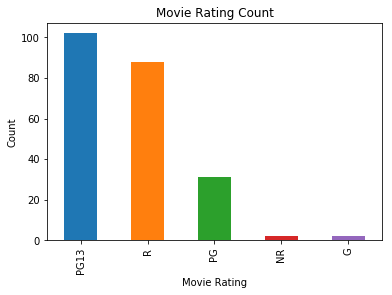

In [69]:
#count of category occurence in data
movies.Rating.value_counts().plot(kind = "bar")
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Movie Rating Count');

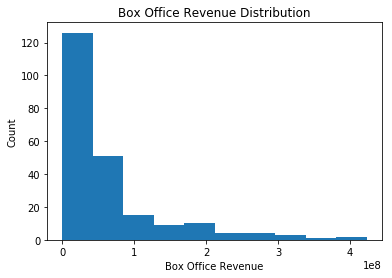

In [71]:
#count of category occurence in data
plt.hist(movies["BoxOffice"])
plt.xlabel('Box Office Revenue')
plt.ylabel('Count')
plt.title('Box Office Revenue Distribution');

# Critical vs Popular Ratings

''

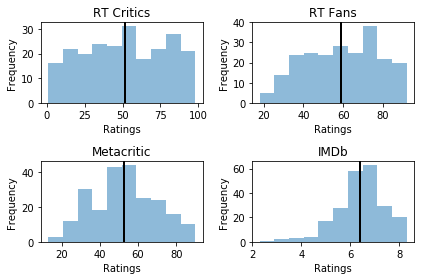

In [39]:
plt.subplot(2,2,1, )
plt.hist(movies['RTCritic'], label="RT Critic", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Critics')
plt.axvline(movies["RTCritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,2)
plt.hist(movies['RTFan'], label="RT Fan", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('RT Fans')
plt.axvline(movies["RTFan"].mean(), color='black', linewidth=2)

plt.subplot(2,2,3)
plt.hist(movies['Metacritic'], label="Metacritic", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Metacritic')
plt.tight_layout()
plt.axvline(movies["Metacritic"].mean(), color='black', linewidth=2)

plt.subplot(2,2,4)
plt.hist(movies['IMDb'], label="IMDb", alpha=0.5)
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('IMDb')
plt.tight_layout()
plt.axvline(movies["IMDb"].mean(), color='black', linewidth=2)
;

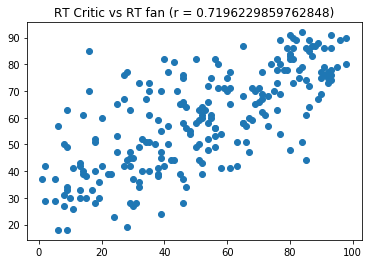

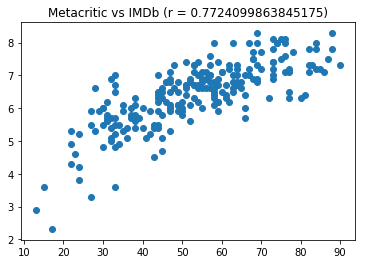

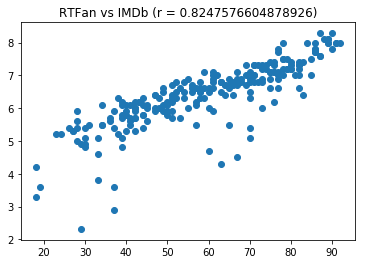

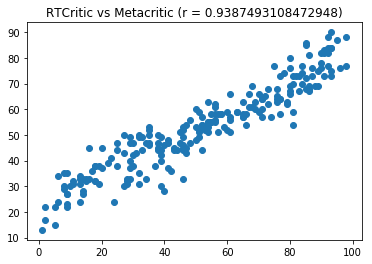

In [67]:
x = movies["RTCritic"]
y = movies["RTFan"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs RT fan (r = {})".format(r))
plt.show()

x = movies["Metacritic"]
y = movies["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs IMDb (r = {})".format(r))
plt.show()

x = movies["RTFan"]
y = movies["IMDb"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTFan vs IMDb (r = {})".format(r))
plt.show()

x = movies["RTCritic"]
y = movies["Metacritic"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RTCritic vs Metacritic (r = {})".format(r))
plt.show()


# Ratings as predictors of box office revenue

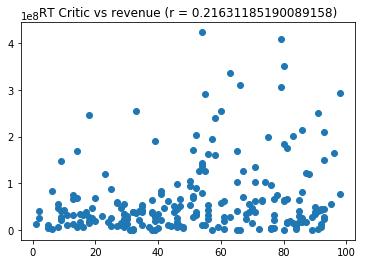

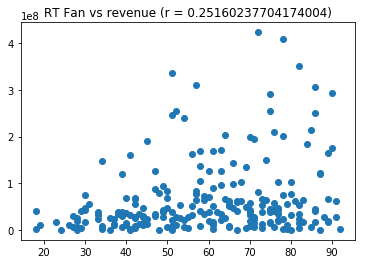

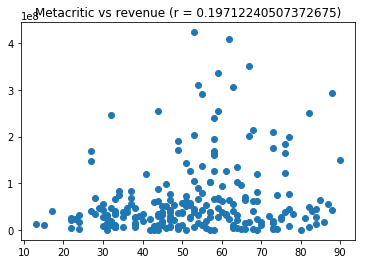

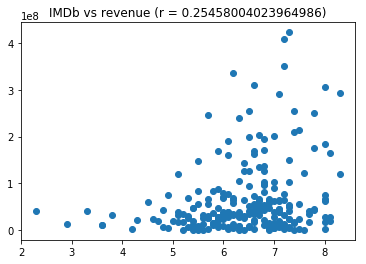

In [63]:
x = movies["RTCritic"]
y = movies["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Critic vs revenue (r = {})".format(r))
plt.show()

x = movies["RTFan"]
y = movies["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("RT Fan vs revenue (r = {})".format(r))
plt.show()

x = movies["Metacritic"]
y = movies["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("Metacritic vs revenue (r = {})".format(r))
plt.show()

x = movies["IMDb"]
y = movies["BoxOffice"]
plt.scatter(x,y)
r = np.corrcoef(x,y)[0,1]
plt.title("IMDb vs revenue (r = {})".format(r))
plt.show()


# Possible Factors in Critical-vs-Popular rating discrepancies

In [ ]:
movies["allFans"] = (movies["IMDb"] + movies["RTFans"])/2
movies["allCritics"] = (movies["RTCritic"] + movies["Metacritic"])/2
movies["discrepancy"] = abs(movies["allFans"] - movies["allCritics"])
movies["normDiscrepancy"] = abs( (movies["allFans"] - movies["allFans"].mean()) - )